In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from collections import defaultdict

import stumpy

In [11]:
def load_npy(filename):
    return np.load(filename)
path = "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/Output/X_y_ids.npz"
# reload 
X_y_ids = load_npy(f"{path}") 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']


In [12]:
#per trasformare in dataframe

df = pd.DataFrame(np.squeeze(X))
df["genre"] = y
df.shape


(10000, 1281)

In [13]:
a = ['happy','piano']
df_filtered = df[df['genre'].isin(a)] 
df_filtered.shape


(1000, 1281)

In [14]:
# Assegna la variabile target
y = df_filtered.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df_filtered.iloc[:, :-1].values
X.shape, y.shape


((1000, 1280), (1000,))

In [15]:
from sklearn.preprocessing import LabelEncoder

# Inizializza e addestra il LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [16]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import numpy as np
from tslearn.metrics import dtw


# Definiamo il numero di classi di genere musicale
num_classi = 2

# Inizializziamo un dizionario per memorizzare i centroidi per ciascuna classe di genere musicale
centroidi_per_classe = {}

# Convertiamo le serie temporali in un formato compatibile con tslearn
#X = to_time_series_dataset(X)

# Dividiamo il dataset in subset per ogni classe di genere musicale
for classe in range(num_classi):
    subset_X = X[y_encoded == classe]  # Seleziona solo le serie temporali appartenenti alla classe corrente
    kmeans = TimeSeriesKMeans(n_clusters=1, metric= "euclidean", verbose=0, random_state=42).fit(subset_X)  # Esegui TimeSeriesKMeans con k=1
    centroidi_per_classe[classe] = kmeans.cluster_centers_[0]  # Salva il centroide per la classe corrente


In [17]:
centroidi_per_classe


{0: array([[2997.19839046],
        [2978.42941568],
        [2970.81105579],
        ...,
        [2854.73276492],
        [2839.3016486 ],
        [2801.58333856]]),
 1: array([[925.99570759],
        [941.19267866],
        [965.6552027 ],
        ...,
        [955.3910824 ],
        [951.40904176],
        [932.4140462 ]])}

In [18]:
c0 = centroidi_per_classe[0]
c1 = centroidi_per_classe[1]

<function matplotlib.pyplot.show(close=None, block=None)>

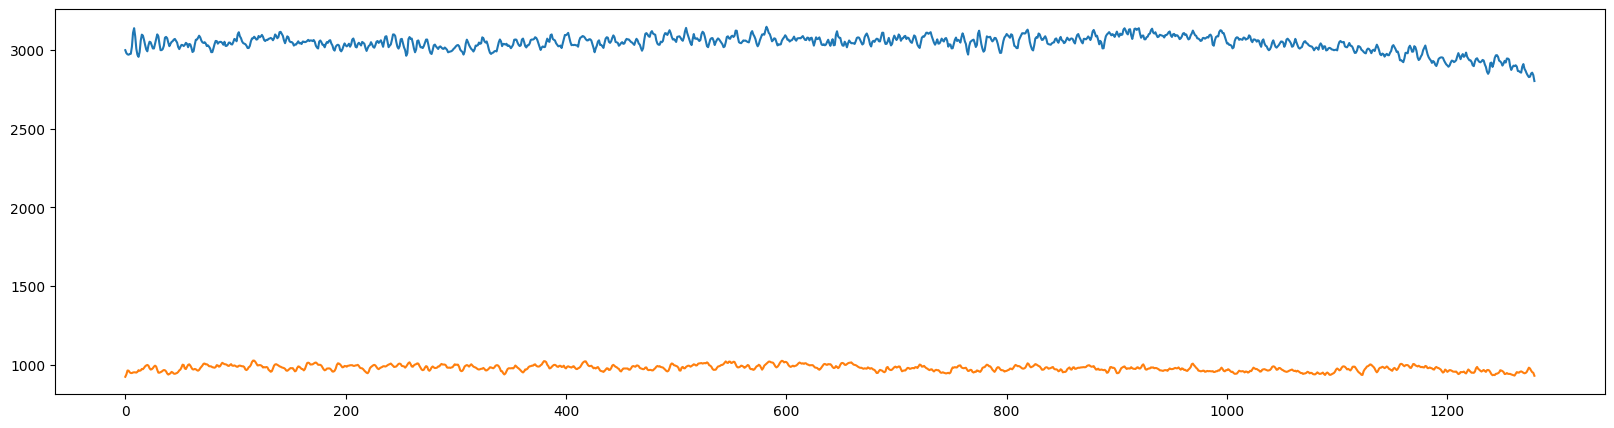

In [19]:
plt.figure(figsize=(20,5))
plt.plot(c0)
plt.plot(c1)
plt.show


In [20]:
centr = np.array([c0,c1])
centr = centr.squeeze()
centr.shape

(2, 1280)

In [21]:
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from pyts.approximation import DiscreteFourierTransform
from tslearn.clustering import silhouette_score 


# Get the centroids
def getNearestTS(data, centroids):
    centroids = np.squeeze(centroids)

    # Function to calculate DTW distance between two time series
    def dtw_distance(ts1, ts2):
        distance, _ = fastdtw(ts1, ts2)
        return distance

    # Calculate the distance between each centroid and all time series data points
    distances = cdist(centroids, data, metric=dtw_distance) #euclidean?

    # Find the nearest time series for each centroid
    nearest_indices = np.argmin(distances, axis=1)

    # Retrieve the nearest time series for each centroid
    #nearest_time_series = [x_train_dft[i] for i in nearest_indices]

    # Print the results
    for i, centroid in enumerate(centroids):
        print (f"Centroid {i}: Nearest Time Series Index = {nearest_indices[i]}")


In [22]:
getNearestTS(X,centr)

Centroid 0: Nearest Time Series Index = 806
Centroid 1: Nearest Time Series Index = 788


In [86]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series


X_app = X.copy()

w = 10 
for i,time_series in enumerate(X_app):
    X_app[i]= moving_average_smoothing(X_app[i], w)


<function matplotlib.pyplot.show(close=None, block=None)>

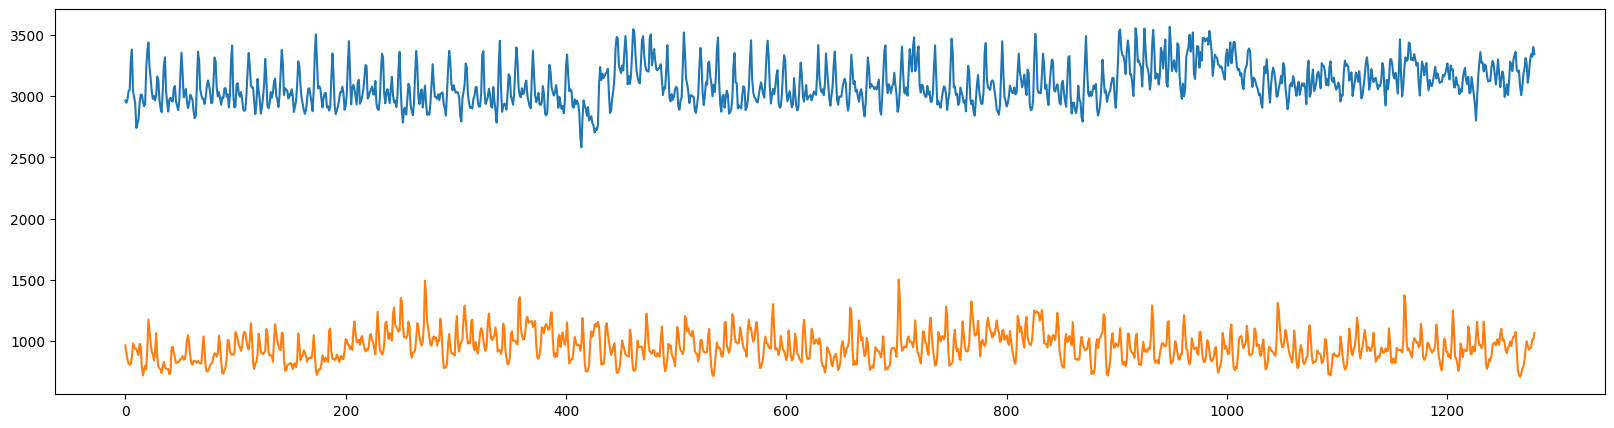

In [87]:
plt.figure(figsize=(20,5))
plt.plot(X[806])
plt.plot(X[788])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

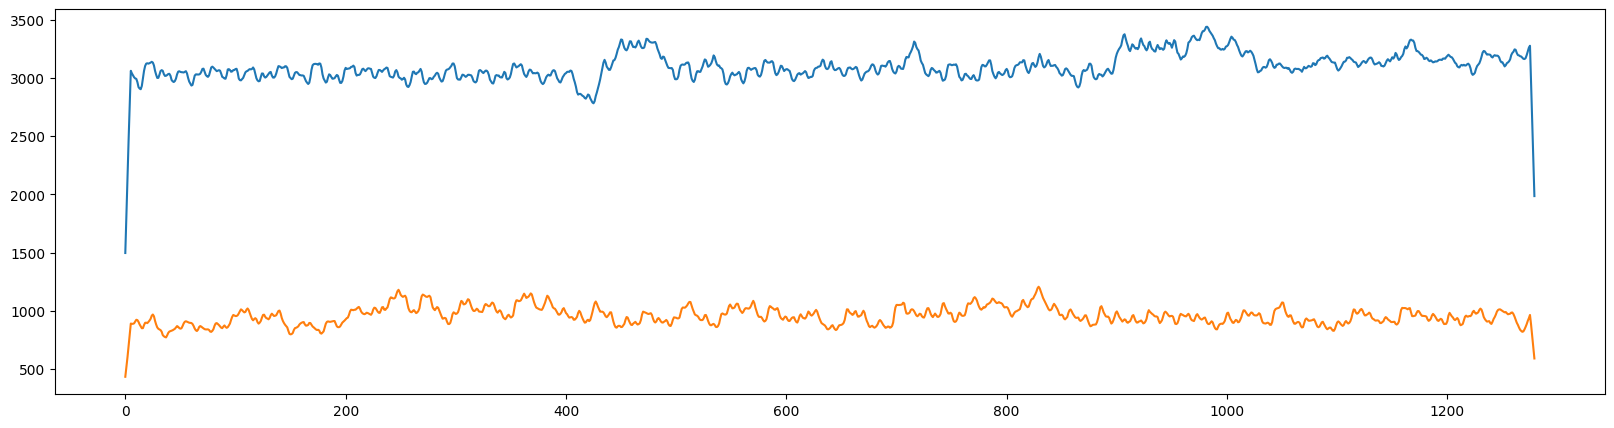

In [88]:
#plotto

ts0 = X_app[806]
ts1 = X_app[788]

# ts0 = X_app[474]
# ts1 = X_app[345]

plt.figure(figsize=(20,5))
plt.plot(ts0)
plt.plot(ts1)
plt.show


In [89]:
from pyts.approximation import PiecewiseAggregateApproximation

window_size = 4

paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X_app)
X_paa.shape


(1000, 320)

<function matplotlib.pyplot.show(close=None, block=None)>

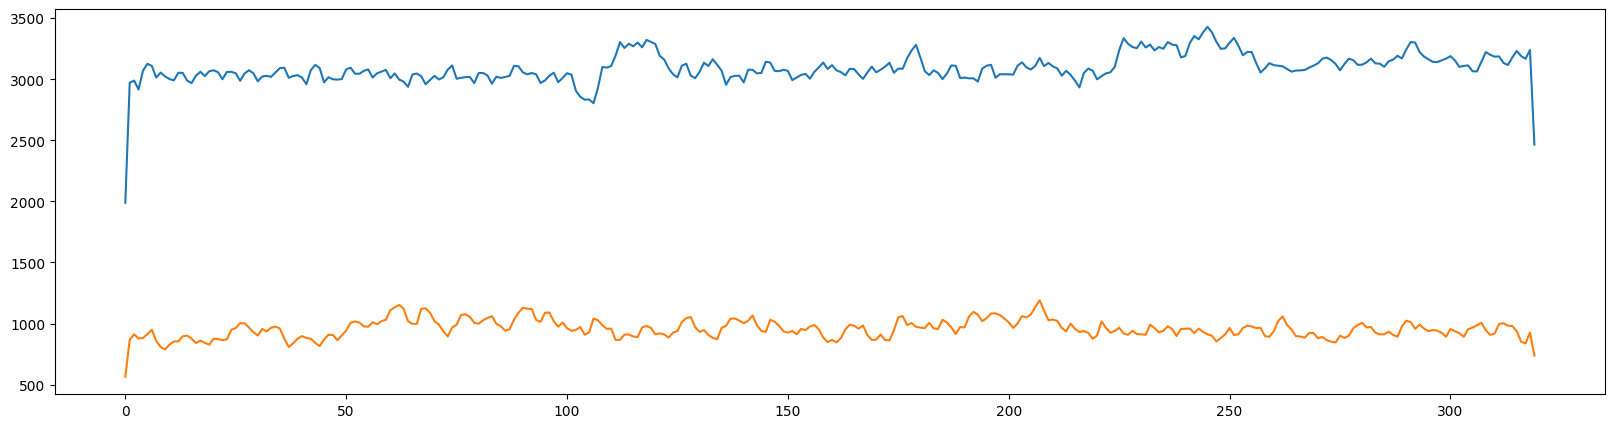

In [90]:
ts0_paa = X_paa[806]
ts1_paa = X_paa[788]

# ts0 = X_app[474]
# ts1 = X_app[345]

plt.figure(figsize=(20,5))
plt.plot(ts0_paa)
plt.plot(ts1_paa)
plt.show


In [91]:
tsX = pd.Series(ts1)
tsX

0       434.547173
1       516.158392
2       603.737063
3       702.007258
4       798.063733
           ...    
1275    965.454664
1276    881.127565
1277    787.763290
1278    687.966417
1279    591.683343
Length: 1280, dtype: float64

In [92]:
w = 15  # Smaller window size
mp = stumpy.stump(tsX.values, w)


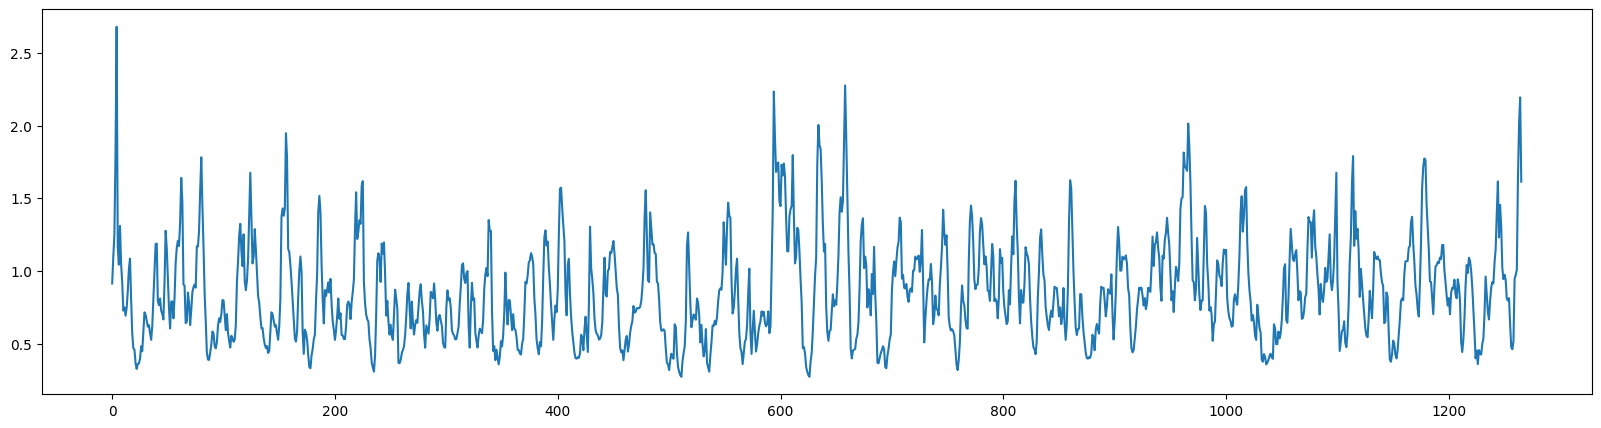

In [93]:
plt.figure(figsize=(20,5))
plt.plot(mp.P_)  # First column: matrix profile
plt.show()

In [96]:
mod, mo  = stumpy.motifs(tsX.values, mp.P_, max_matches=10, max_motifs= 5, cutoff=None, max_distance=None)
mod, mo

(array([[0.        , 0.27184741, 0.47851352, 0.51196558, 0.54236947,
         0.62494513, 0.66028231, 0.68237877]]),
 array([[511, 626,  24, 382, 828, 282, 568, 139]]))

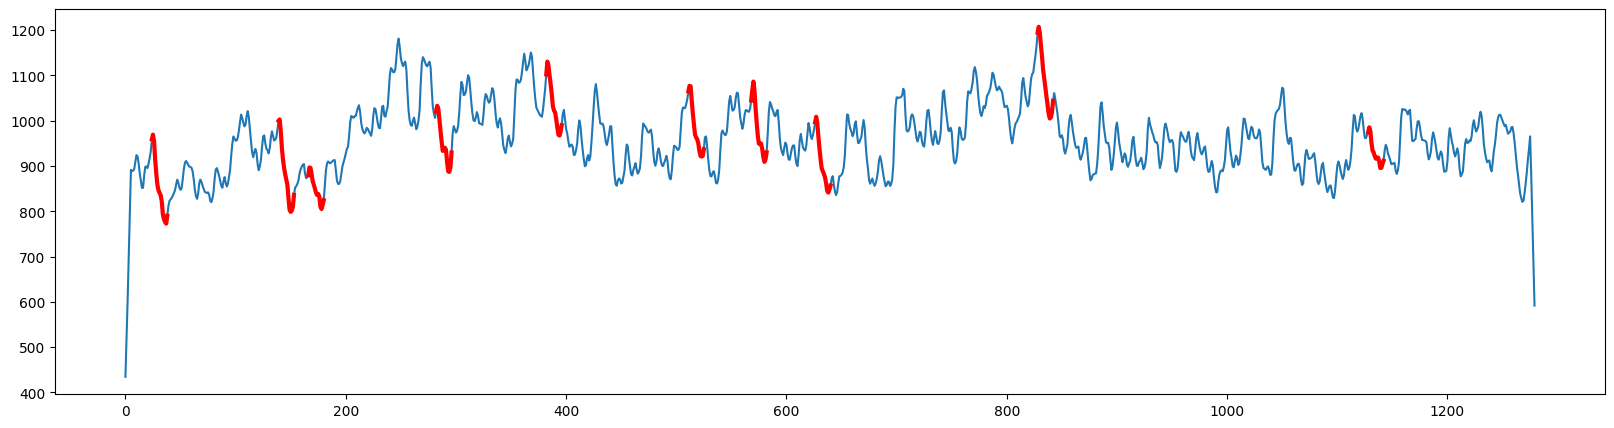

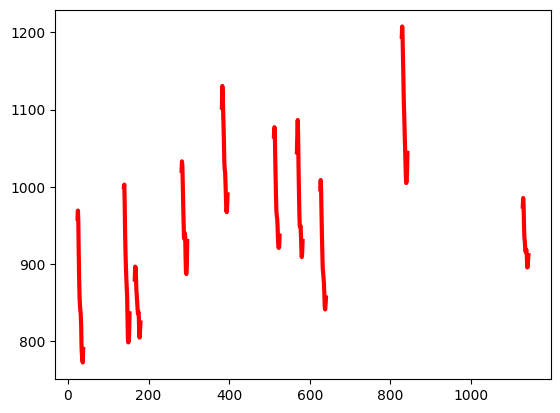

<Figure size 2000x500 with 0 Axes>

In [63]:
plt.figure(figsize=(20,5))
plt.plot(tsX.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]   #sono 10
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()


In [64]:
tsX = pd.Series(ts0)

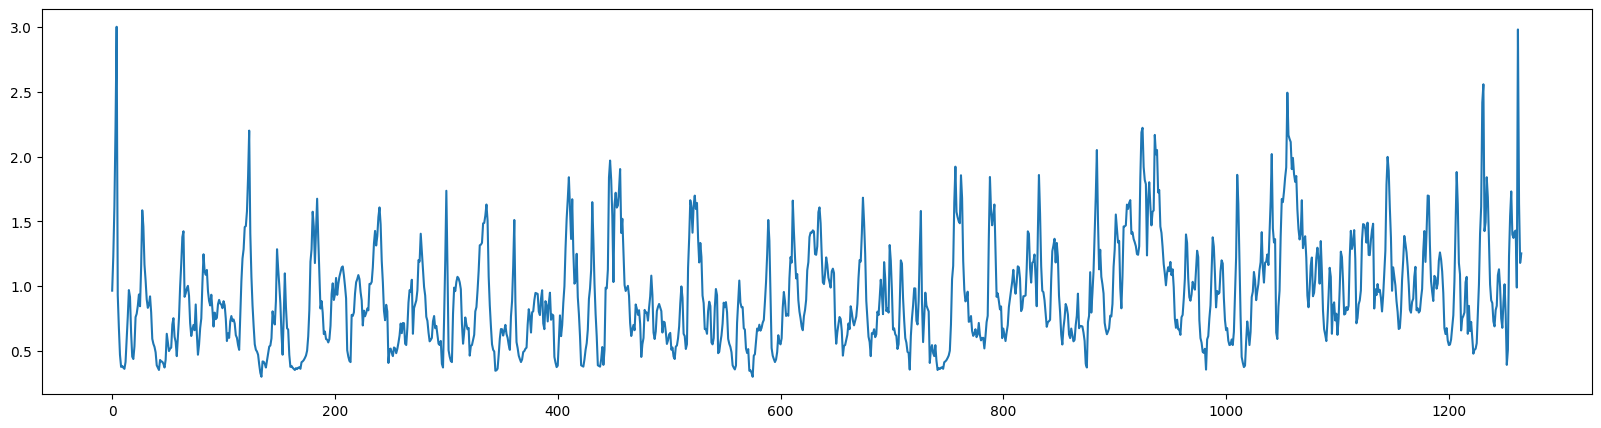

(array([[134, 575, 560,  43, 545, 742, 347, 165, 256, 195]]),
 array([[0.        , 0.29805931, 0.3850337 , 0.46104405, 0.4914756 ,
         0.51502817, 0.51703871, 0.60719917, 0.6605432 , 0.73601323]]))

In [65]:
w = 15
matrix_profile = stumpy.stump(tsX.values, w)
mp = matrix_profile[:, 0]
mpi = matrix_profile[:, 1]

plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()
tsX

mod, mo  = stumpy.motifs(tsX.values, mp, max_motifs= 10)
mo,mod

# ho sull'asse delle X solamente 50000 valori perchè ho ristretto la finestra


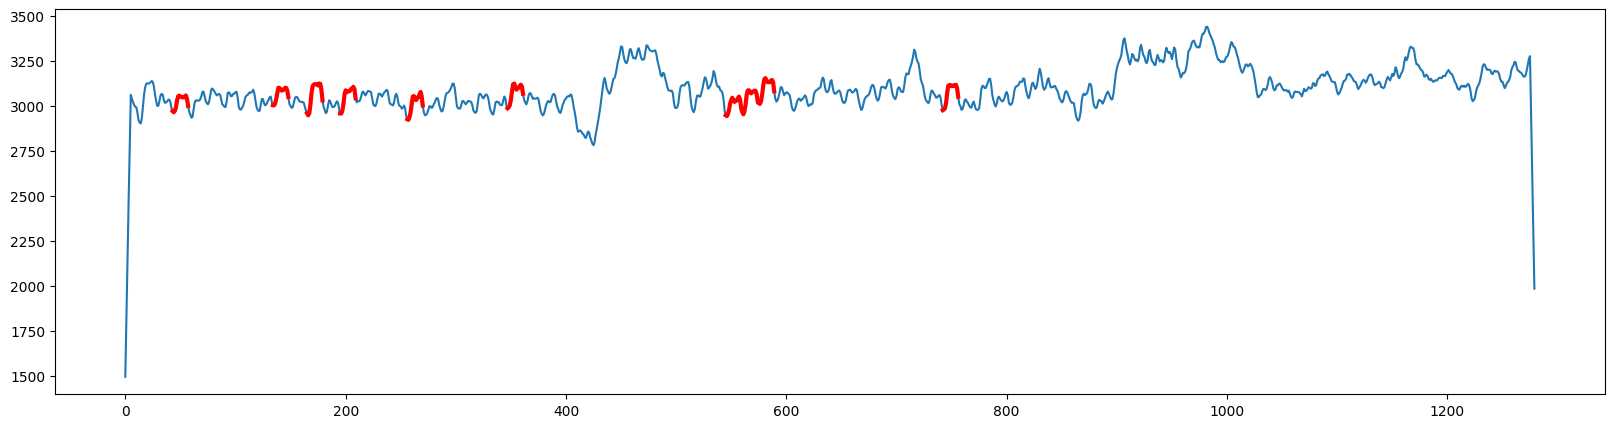

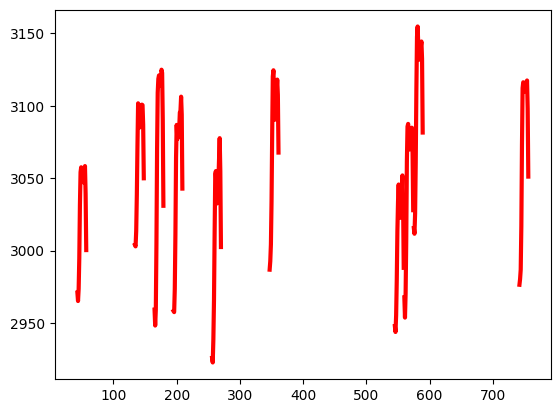

<Figure size 2000x500 with 0 Axes>

In [66]:
plt.figure(figsize=(20,5))
plt.plot(tsX.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

In [69]:
tsX_paa = pd.Series(ts1_paa)
tsX_paa


0      564.112471
1      866.975246
2      912.008925
3      877.198556
4      881.983433
          ...    
315    936.793822
316    851.590758
317    837.022974
318    926.075410
319    737.135154
Length: 320, dtype: float64

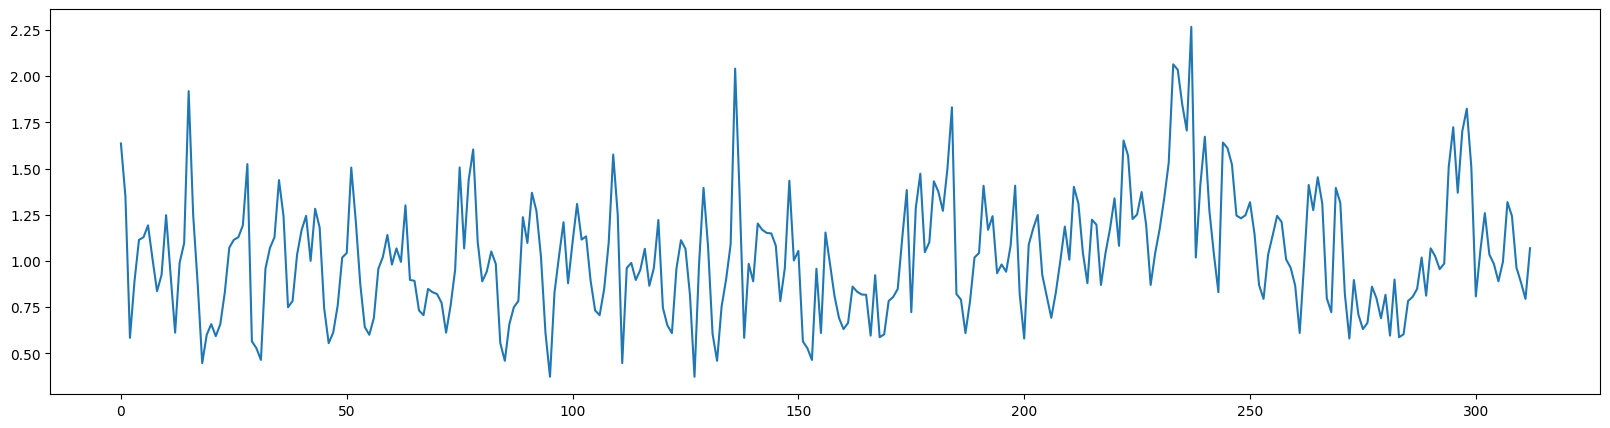

Motifs (starting indices): [[ 95 127 206 210 106  67]]
Motif Nearest Neighbors: [[0.         0.37366163 0.92904893 1.00703252 1.06769381 1.13993433]]


In [70]:



w = 8
matrix_profile = stumpy.stump(tsX_paa.values, w)
mp = matrix_profile[:, 0]
mpi = matrix_profile[:, 1]

# Discover motifs
mo, mod = stumpy.motifs(tsX_paa.values, mp, max_motifs=10)

plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()
tsX_paa

mod, mo = stumpy.motifs(tsX_paa.values, mp, max_motifs=10)
print("Motifs (starting indices):", mo)
print("Motif Nearest Neighbors:", mod)



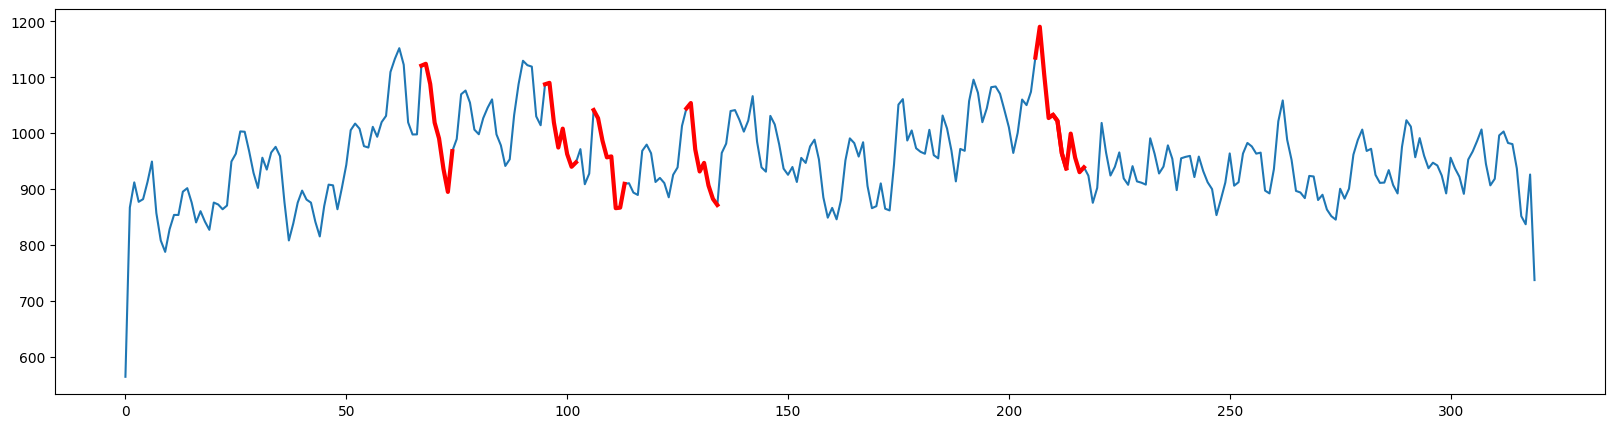

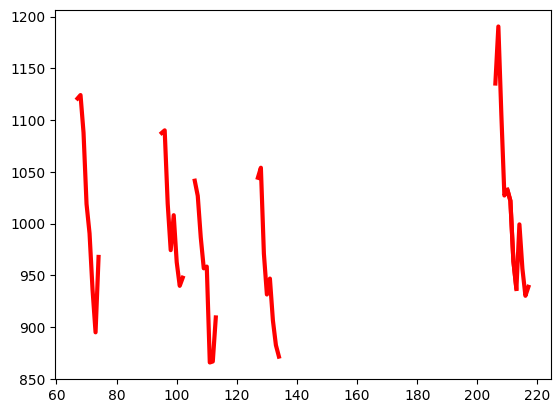

<Figure size 2000x500 with 0 Axes>

In [71]:
plt.figure(figsize=(20,5))
plt.plot(tsX_paa.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()
